# Import Raman_analyzer

In [40]:
from Raman_analyzer import *
import importlib
importlib.reload(Raman_analyzer)

<module 'Raman_analyzer' from '/Users/mykytakizilov/projects/graduate_school/Raman_analyzer/Raman_analyzer.py'>

# Data Import
In our example we will have 2 data packs: API and background. For API and background spectra was recorded several times to improve statistics.

In [7]:
# Importing data from the files. The data is stored in a list of dataframes, each dataframe corresponds to one recorded spectra. Probably you won't be able to parce data for your type of file, so you need to write your own function to do that.
# You just need to create a dataframe with two columns: "Wavenumber" and "Intensity". The first one should contain the Raman shift values and the second one should contain the corresponding intensity values.
df_API_list, filenames_API = create_dataframe_list("data", "API")
df_back_list, filenames_back = create_dataframe_list("data", "Back")

Lets see how does our data look like

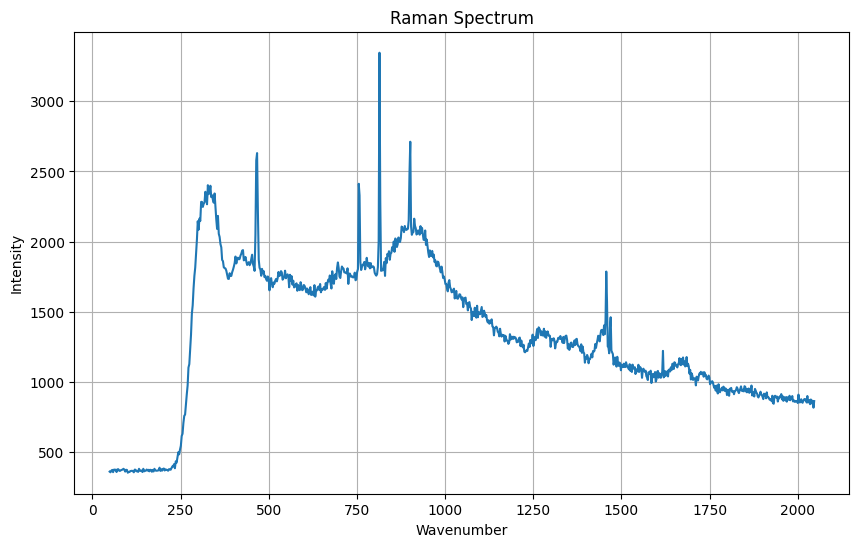

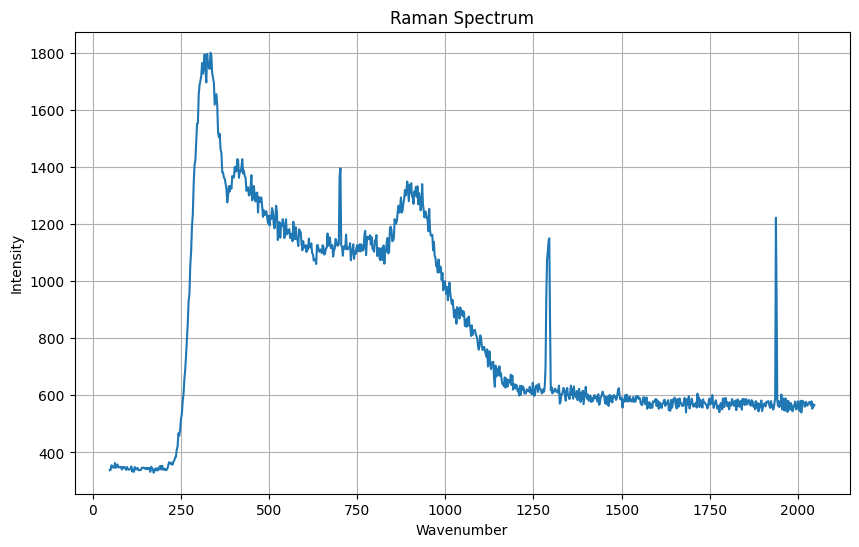

In [8]:
plot_raman(df_API_list[0])
plot_raman(df_back_list[0])

# Data Pre-Processing
## Cut the data
Now cut the data for desired range.

In [9]:
# Cutting the data
for i in range(len(df_API_list)):
    df_API_list[i] = cut_dataframe(df_API_list[i], 400, 2000)
for i in range(len(df_back_list)):
    df_back_list[i] = cut_dataframe(df_back_list[i], 400, 2000)

## Despiking the data

In [10]:
df_API_list_despiked = df_API_list.copy()
for i in range(len(df_API_list)):
    df_API_list_despiked[i] = despike_spectrum(df_API_list[i], 8, 1.5, plot=False)
    
df_back_list_despiked = df_back_list.copy()
for i in range(len(df_back_list)):
    df_back_list_despiked[i] = despike_spectrum(df_back_list[i], 8, 1.5, plot=False)

Lets look how data with spikes and despiked look like. To get nice result with your own data adjust moving_average and z-score threshold.

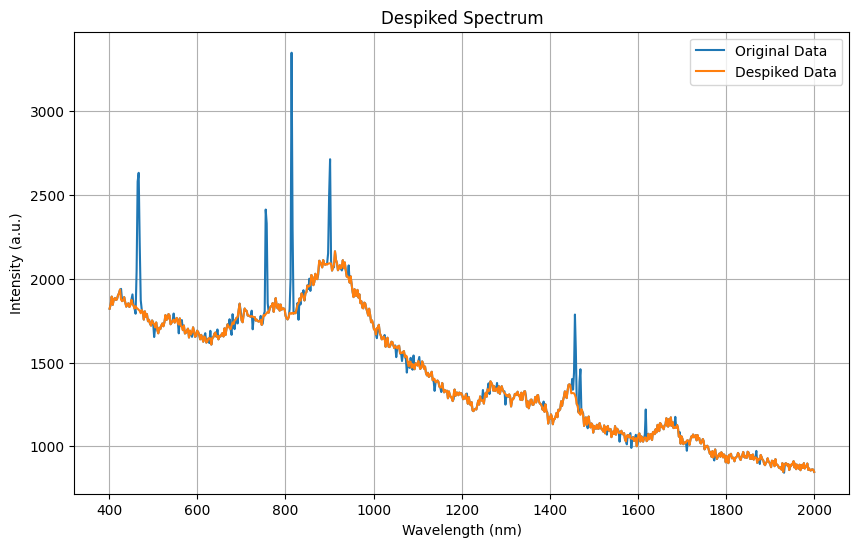

,Wavenumber,Intensity
0,400.91516,1821.0
1,403.27844,1847.0
2,405.64114,1893.0
3,408.00320,1844.0
4,410.36469,1876.0
...,...,...
742,1992.15750,856.0
743,1994.10030,862.0
744,1996.04460,863.0
745,1997.98830,861.0


In [11]:
despike_spectrum(df_API_list[0], 8, 1.5, plot=True)

## If you recorded one spectra several times, you can average them to decrease noise and improve statistics

In [16]:
df_API = average_dataframes(df_API_list_despiked)
df_back = average_dataframes(df_back_list_despiked)


## Substracting the background
Remember that our Intensities are in abribtrary units so we have to normalize our dataframes before substraction. For normalization region it's better to choose region w\o spikes.

In [18]:
# Normalizing the data
df_API_normalized = normalize_spectrum(df_API, 500, 1000)
df_back_normalized = normalize_spectrum(df_back, 500, 1000)

# Subtracting the background
df_API_normalized_subtracted = remove_background(df_API_normalized, df_back_normalized)

## Smoothing the data

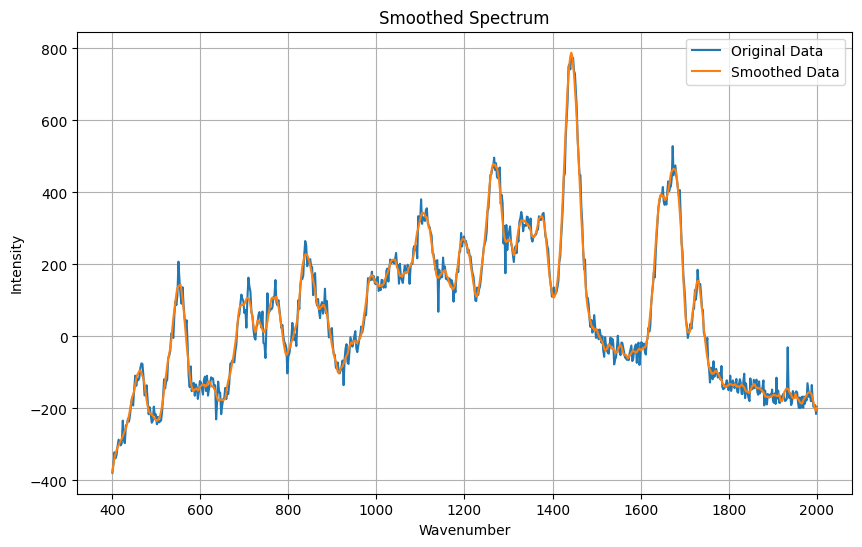

In [20]:
df_API_smoothed = smooth_spectrum(df_API_normalized_subtracted, 20, 5, plot=True)

## Baseline Separation

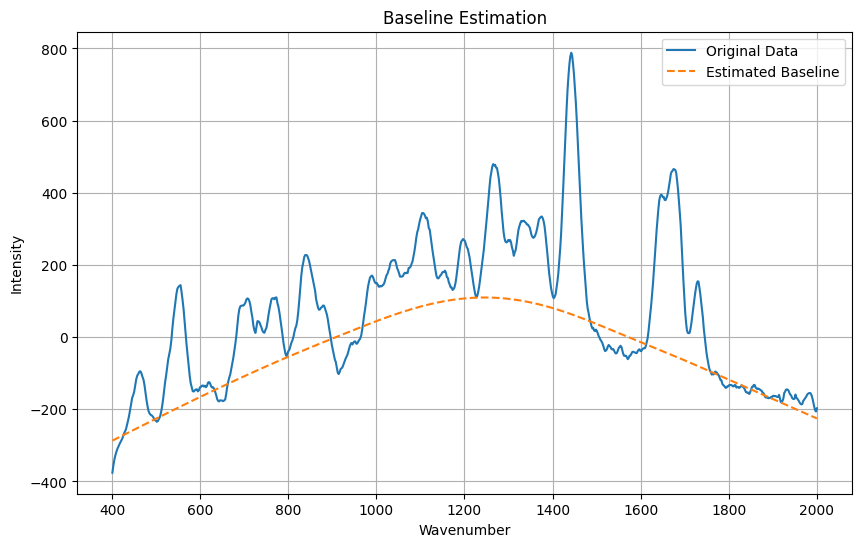

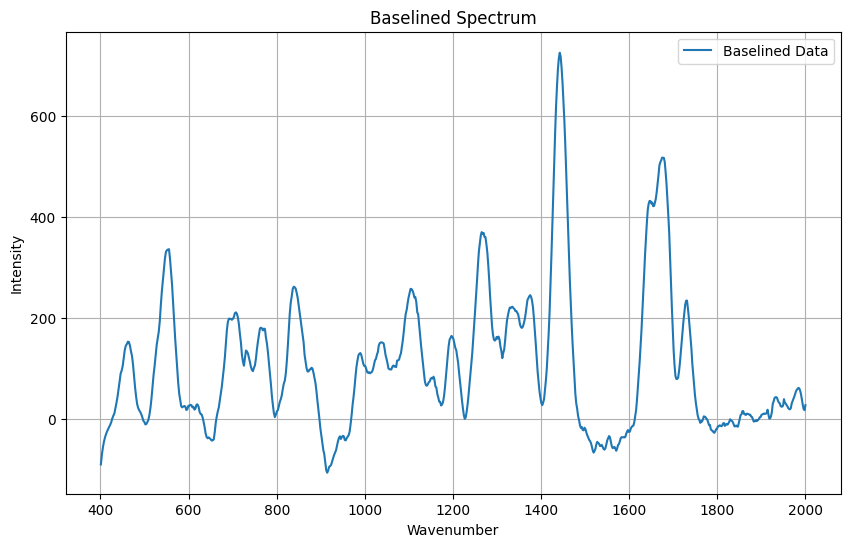

In [59]:
df_API_baselined = estimate_baseline(df_API_smoothed, plot=True)

## Arranging the data
Some of Intensity values might be negative. Lets shift all data so all intensities will be > 0.

In [60]:
df_API_final = shift_counts_to_zero(df_API_baselined)

# Data Analysis
## Find peaks and fit lorenzians
To get a nice fit you need to play with fitting values. Sometimes it happens that it doesn't find one of the peaks, in that case you can add it (or remove) manually.

/var/folders/nw/8dk2cczn3fdbjmqybvvdjykc0000gn/T/ipykernel_8212/2824448718.py:60: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(xs, fit, 'r-', label='Fit', color='red', lw=2, ls='--', alpha=0.6)
/var/folders/nw/8dk2cczn3fdbjmqybvvdjykc0000gn/T/ipykernel_8212/2824448718.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax1.plot(xs, fit, 'r-', label='Fit', color='red', lw=2, ls='--', alpha=0.6)


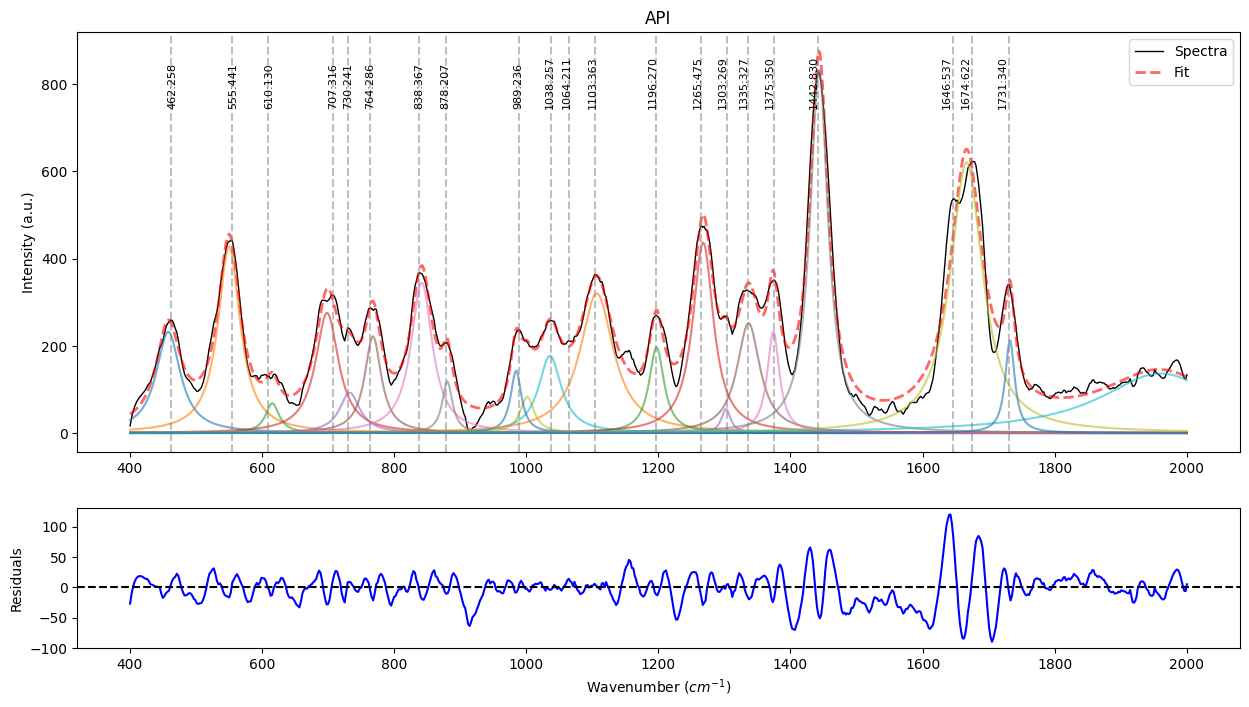

(array([ 458.68315401,  232.17291556,   22.24351118,  550.71325634,
         428.2912954 ,   20.40534038,  616.05560702,   68.45500442,
          12.59546107,  698.89742507,  275.90665022,   21.21584386,
         733.1520963 ,   92.81976779,   18.68013971,  768.37042348,
         222.36556923,   15.24623477,  842.075216  ,  345.31068631,
          19.61330622,  880.89992531,  118.70806889,    9.44469711,
        1001.62053249,   83.09016368,   12.97141407, 1036.21310077,
         177.33037784,   21.0199998 ,  984.89032725,  143.41712793,
           9.95264501, 1107.017964  ,  320.24847784,   30.84138846,
        1197.40582555,  197.11752808,   13.75455656, 1267.89452438,
         437.29309982,   19.06211078, 1302.51250231,   55.33870848,
           8.45146001, 1336.58120817,  252.26382638,   21.18144014,
        1374.13631564,  233.9951439 ,   11.16202021, 1443.2818694 ,
         835.04023278,   16.54058273, 1666.45859459,  621.36240739,
          29.72508886, 1960.07049636,  136.65416

In [62]:
fit_lorentzians(df_API_final, n_peaks_to_find=25, title="API", remove_peaks_ranges=[[990, 1010], [1070, 1100]], add_peaks=[610], threshold=0.23, min_dist=7)